In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [ ]:
!unzip -q converted.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: MUS


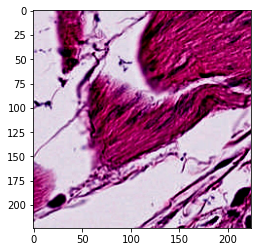

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
class Residualblock(nn.Module):
    def __init__(self, in_channel, out_channel, Conv=False, strides=1):
        super().__init__()
        self.convolution1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=strides)
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.convolution2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)

        if Conv:
            self.convolution3 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides)
        else:
            self.convolution3 = None

    def forward(self, X):
        out = F.relu(self.batchnorm1(self.convolution1(X)))
        out = self.batchnorm2(self.convolution2(out))
        if self.convolution3:
            X = self.convolution3(X)
        out += X
        return F.relu(out)

def residualBlock(in_channel, out_channel, num_residuals, first_block=False):
    blks = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blks.append(Residualblock(in_channel, out_channel, Conv=True,
            strides=2))
        else:
            blks.append(Residualblock(out_channel, out_channel))
    
    return blks

class ResNet(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*residualBlock(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*residualBlock(64, 128, 2))
        self.b4 = nn.Sequential(*residualBlock(128, 256, 2))
        self.b5 = nn.Sequential(*residualBlock(256, 512, 2))
        self.finalLayer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),nn.Linear(512, n_classes))

        self.b1.apply(self.initialweight)
        self.b2.apply(self.initialweight)
        self.b3.apply(self.initialweight)
        self.b4.apply(self.initialweight)
        self.b5.apply(self.initialweight)
        self.finalLayer.apply(self.initialweight)

    def initialweight(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        


    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.finalLayer(out)

        return out

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNetV1(input_channel=3, n_classes=9).to(device)
learning_rate = 0.0002
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("MobileNet9categoriesmodel.pth"):
        os.remove("MobileNet9categoriesmodel.pth")

      torch.save(model.state_dict(), 'MobileNet9categoriesmodel.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)

!cp MobileNet9categoriesmodel.pth '/content/drive/My Drive/Histopathology data/'

train_l=str(train_loss)
test_l=str(test_loss)
accuracy_t=str(accuracy_test)

output_file = open('training_accuracy.txt', 'w')

for t in train_l:
    output_file.write(t)

output_file.close()


output_file = open('test_loss.txt', 'w')

for t in test_l:
    output_file.write(t)

output_file.close()

output_file = open('accuracy_test.txt', 'w')

for t in accuracy_t:
    output_file.write(t)

output_file.close()


1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.2625

Test: Average loss: 0.7706, Accuracy: 3919/5400 (72.57%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8083

Test: Average loss: 0.5079, Accuracy: 4380/5400 (81.11%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6133

Test: Average loss: 0.3864, Accuracy: 4724/5400 (87.48%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5078

Test: Average loss: 0.3661, Accuracy: 4729/5400 (87.57%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4366

Test: Average loss: 0.2975, Accuracy: 4884/5400 (90.44%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3779

Test: Average loss: 0.3245, Accuracy: 4965/5400 (91.94%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3352

Test: Average loss: 0.2248, Accuracy: 5005/5400 (92.69%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2937

Test: Average loss: 0.2503, Accuracy: 4976/5400 (92.15%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2644

Test: Average loss: 0.2479, Accuracy: 4949/5400 (91.65%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2410

Test: Average loss: 0.2330, Accuracy: 4959/5400 (91.83%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2243

Test: Average loss: 0.2088, Accuracy: 5107/5400 (94.57%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2047

Test: Average loss: 0.1538, Accuracy: 5140/5400 (95.19%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1911

Test: Average loss: 0.2228, Accuracy: 5007/5400 (92.72%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1846

Test: Average loss: 0.1809, Accuracy: 5112/5400 (94.67%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1613

Test: Average loss: 0.1396, Accuracy: 5159/5400 (95.54%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1598

Test: Average loss: 0.1903, Accuracy: 5135/5400 (95.09%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1437

Test: Average loss: 0.1847, Accuracy: 5105/5400 (94.54%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1419

Test: Average loss: 0.1405, Accuracy: 5145/5400 (95.28%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1356

Test: Average loss: 0.1542, Accuracy: 5140/5400 (95.19%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1367

Test: Average loss: 0.1335, Accuracy: 5168/5400 (95.70%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1185

Test: Average loss: 0.1334, Accuracy: 5192/5400 (96.15%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1210

Test: Average loss: 0.1274, Accuracy: 5173/5400 (95.80%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1192

Test: Average loss: 0.2185, Accuracy: 5025/5400 (93.06%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1072

Test: Average loss: 0.2513, Accuracy: 5001/5400 (92.61%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1131

Test: Average loss: 0.1148, Accuracy: 5199/5400 (96.28%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1093

Test: Average loss: 0.1774, Accuracy: 5129/5400 (94.98%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0996

Test: Average loss: 0.1572, Accuracy: 5149/5400 (95.35%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1044

Test: Average loss: 0.1507, Accuracy: 5133/5400 (95.06%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0990

Test: Average loss: 0.1215, Accuracy: 5179/5400 (95.91%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0897

Test: Average loss: 0.1286, Accuracy: 5187/5400 (96.06%)



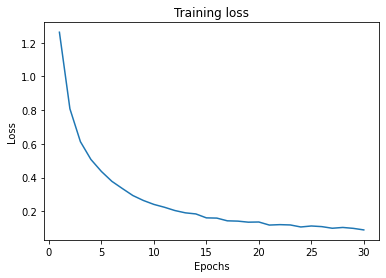

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

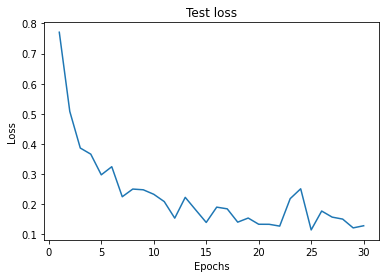

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

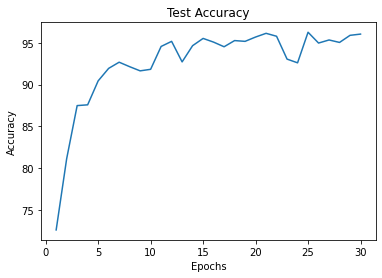

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()